---
### Universidad de Costa Rica
#### IE0315 - Máquinas Eléctricas I

Primer ciclo del 2023

---

[comment]: <> (Modificar esta sección con datos personales)

* Estudiante: **Marlon Jesús Jiménez Acosta**
* Carné: **B73881**
* Grupo: **1**

# `Proyecto Máquinas Eléctricas I` - *Diseño subestación Zion S.A*




---
## Antecedentes e información disponible:
La junta directiva de la empresa Zion S.A. localizada en el parque industrial New Babilon, tiene
interés de modernizar su subestación (conjunto de equipos de transformación de potencia,
transformadores de medición, protección y seccionamiento) que acopla la red de distribución
interna de la empresa en baja tensión, a la red primaria de distribución del parque industrial de
media tensión, propiedad de la compañía eléctrica.
- Se le proporciona una curva con la potencia trifásica (Curva demanda.xlsx) medida de la
empresa. Esta información se obtuvo de la facturación de la empresa distribuidora que
provee el servicio eléctrico en media tensión a 34.5/19.92 kV.
- Adicionalmente, se le proporciona un catálogo (Catalogo componentes y precios.xlsx) con
los componentes más importantes para construir la subestación. Con esta información,
puede brindar un costo estimado para materiales del proyecto. Considere un costo de
accesorios de un 15% del valor total de los componentes.
- Una vez seleccionados los transformadores de potencia, debe realizar los cálculos eléctricos
a partir de los parámetros en las tablas VIII y IX del artículo
(https://ieeexplore.ieee.org/abstract/document/8596604) y especificar su conexión.
Considere que la tensión secundaria del transformador se puede ajustar a su necesidad de
208/120 V.


Resolución del proyecto

Se importan las librerías y el csv en un dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fitter import Fitter
from scipy import stats
import numpy as np
import tikzplotlib
import numpy as np
import scipy.stats as stats

# Importar CSV en un DataFrame
zion_curve = pd.read_csv('zion.csv', decimal=',', sep=';')

Se crea el histograma y se obtiene la curva de mejor ajuste para la potencia aparente consumida

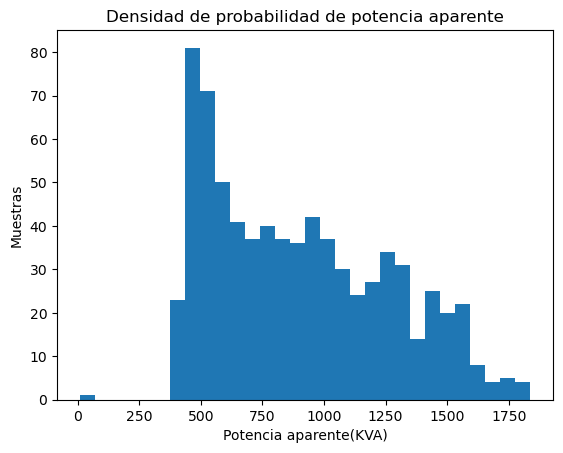

Fitting 110 distributions:  29%|██▉       | 32/110 [00:13<01:13,  1.07it/s]C:\Users\chus1\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:3485: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  t1 = integrate.quad(llc, -np.inf, x)[0]
Fitting 110 distributions:  77%|███████▋  | 85/110 [00:40<00:27,  1.09s/it]SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitting 110 distributions:  84%|████████▎ | 92/110 [00:54<00:47,  2.65s/it]C:\Users\chus1\anaconda3\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and cal

El mejor ajuste de la potencia aparente consumida por Zion S.A es: {'laplace_asymmetric': {'kappa': 0.25133843999796623, 'loc': 450.336528685692, 'scale': 120.45948754545695}}


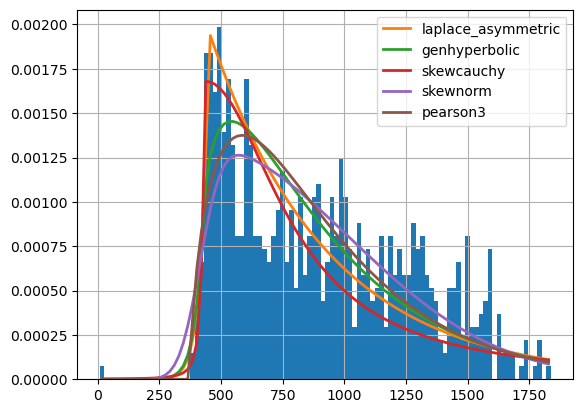

In [2]:
plt.hist(zion_curve['S'], bins=30) #, density=True
plt.title('Densidad de probabilidad de potencia aparente')
plt.xlabel('Potencia aparente(KVA)')
plt.ylabel('Muestras')
# Exportar la figura en formato SVG
plt.savefig('Histograma.svg', transparent=True)
# Se imprime en pantalla la imagen
plt.show()
# Se usa fitter para recorrer las distribuciones y aplicarlas al histograma
Modelos = Fitter(zion_curve['S'].dropna())
Modelos.fit()
Modelos.summary()
summary_1 = Modelos.summary()
with open('Error_modelos.tex', 'w') as f:
    f.write(summary_1.to_latex(index=False))
# La función get_best() permite encontrar el mejor ajuste e imprimir sus
# Parámetros.
mejor_ajuste_S = Modelos.get_best()
print(f"El mejor ajuste de la potencia aparente consumida por Zion S.A es: {mejor_ajuste_S}")


Se obtiene la CDF correspondiente a la curva de potencia consumida,necesaria para obtener una visualización del comportamiento al saber que probabilidad hay de que dada una potencia aparente,la potencia sea igual o menor.

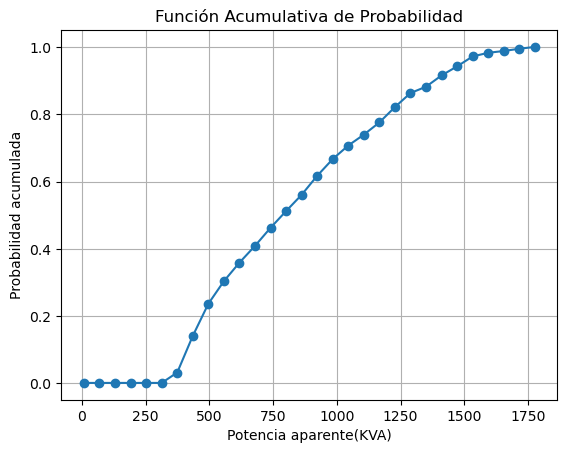

In [3]:

hist, bins = np.histogram(zion_curve['S'], bins=30)

# Calcular la función acumulativa de probabilidad
cumulative_prob = np.cumsum(hist) / np.sum(hist)

# Graficar la función acumulativa de probabilidad
plt.plot(bins[:-1], cumulative_prob, '-o') # Usamos bins[:-1] para eliminar el último bin
plt.title('Función Acumulativa de Probabilidad')
plt.xlabel('Potencia aparente(KVA)')
plt.ylabel('Probabilidad acumulada')
plt.grid(True)
plt.savefig('cdf.svg', transparent=True)
plt.show()


Se puede obtener el valor de probabilidad  de una potencia dada

In [12]:
# Valor de potencia específico
valor_potencia = 1500

# Encontrar el índice del bin correspondiente al valor de potencia
indice_bin = np.searchsorted(bins[:-1], valor_potencia, side='right')

# Obtener la probabilidad acumulada correspondiente al bin
probabilidad = cumulative_prob[indice_bin]

# Imprimir la probabilidad
print(f"La probabilidad acumulada para una potencia de {valor_potencia} KVA es: {probabilidad}")

La probabilidad acumulada para una potencia de 1500 KVA es: 0.9717741935483871


Se calcula la cantidad maxima y minima de horas en sobrecarga a una potencia dada

In [5]:
print(zion_curve.columns)


Index(['Date ', 'time ', 'P ', 'Q ', 'S', 'fp', 'I', 'Día', 'Unnamed: 8'], dtype='object')


In [11]:
import pandas as pd
from datetime import datetime
# Valor especificado de potencia
valor_especificado = 1750

# Crear una columna adicional que indique si la potencia es mayor al valor especificado
zion_curve['Mayor_a_valor'] = zion_curve['S'] > valor_especificado

# Obtener los intervalos de tiempo en los que la potencia es mayor al valor especificado
intervalos_mayor_valor = []
inicio_intervalo = None
for i, row in zion_curve.iterrows():
    if row['Mayor_a_valor'] and inicio_intervalo is None:
        inicio_intervalo = datetime.strptime(row['time '], '%H:%M:%S')
    elif not row['Mayor_a_valor'] and inicio_intervalo is not None:
        fin_intervalo = datetime.strptime(row['time '], '%H:%M:%S')
        duracion_intervalo = fin_intervalo - inicio_intervalo
        intervalos_mayor_valor.append(duracion_intervalo)
        inicio_intervalo = None

# Obtener la duración máxima y mínima de las horas en las que la potencia es mayor al valor especificado
duracion_maxima = max(intervalos_mayor_valor, default=0)
duracion_minima = min(intervalos_mayor_valor, default=0)

# Imprimir los resultados
print(f"La duración máxima de horas con potencia mayor a {valor_especificado} es: {duracion_maxima}")
print(f"La duración mínima de horas con potencia mayor a {valor_especificado} es: {duracion_minima}")


La duración máxima de horas con potencia mayor a 1750 es: 3:00:00
La duración mínima de horas con potencia mayor a 1750 es: 1:00:00


---
**Universidad de Costa Rica** | Facultad de Ingeniería | Escuela de Ingeniería Eléctrica

&copy; 2023

---